# Analisi del Dataset Wine

In questo notebook, eseguiremo una serie di operazioni sul dataset Wine. Il nostro obiettivo è addestrare un modello di classificazione e valutare le sue performance.

## 1. Importazione delle Librerie

Importiamo le librerie necessarie per l'analisi.

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

## 2. Caricamento, suddivisione in dati di training e test e Standardizzazione

Carichiamo il dataset Wine e standardizziamo le caratteristiche.


In [2]:
# Caricamento del dataset "Wine"
data = load_wine()
X, y = data.data, data.target
# Suddivisione del dataset in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [3]:
# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Riduzione della dimensionalità

Riduciamo la dimensione del dataset tramite la Principal Component Analysis (PCA)


In [4]:
# PCA
pca = PCA(n_components=0.80)  # 80% varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

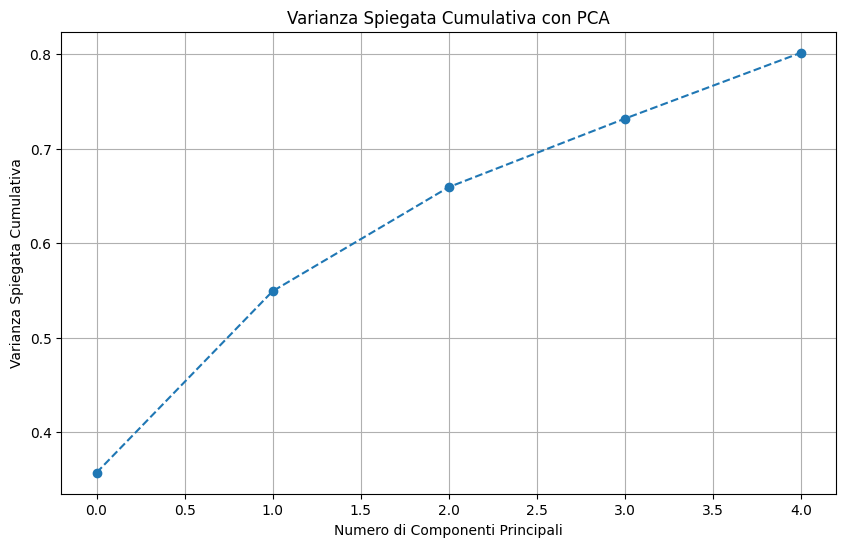

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizzare la varianza spiegata da ogni componente principale
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata Cumulativa con PCA')
plt.grid()
plt.show()

## 4. Modello

Applichiamo l'algoritmo `GradientBoostingClassifier`.

Il Gradient Boosting Classifier è un modello di apprendimento supervisionato basato su un ensemble di alberi decisionali deboli 
(di solito decision trees poco profondi) che vengono addestrati in modo iterativo. Il suo obiettivo è migliorare le prestazioni ad ogni passo, 
correggendo gli errori commessi dai modelli precedenti.

In [6]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)


## 5. Ottimizzazione degli iperparametri 

Ottimizzazione degli iperparametri con RandomizedSearchCV e Uso di StratifiedKFold per mantenere le proporzioni delle classi

In [7]:
iperparametri = {
    'n_estimators': [200,300,400], ## numero alberi
    'learning_rate': [0.01, 0.1, 0.05], 
    'max_depth': [3, 5, 7], ## 
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split' : [3,5,7], ## numero minimo per splittare un nodo, altrimenti diventa leaf
    'min_samples_leaf' : [1,3,5] ## numero minimo richiesto in un leaf
}


skf = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(gbc, iperparametri, n_iter=50, cv=skf, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train_pca, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.05],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [3, 5, 7],
                                        'n_estimators': [200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

## 6. Valutazione delle prestazioni sul test set

A stampa l'accuratezza della classificazione

In [8]:

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

# Output dei risultati
random_search.best_params_, round(accuracy,3)

({'subsample': 0.6,
  'n_estimators': 400,
  'min_samples_split': 7,
  'min_samples_leaf': 5,
  'max_depth': 7,
  'learning_rate': 0.1},
 0.889)

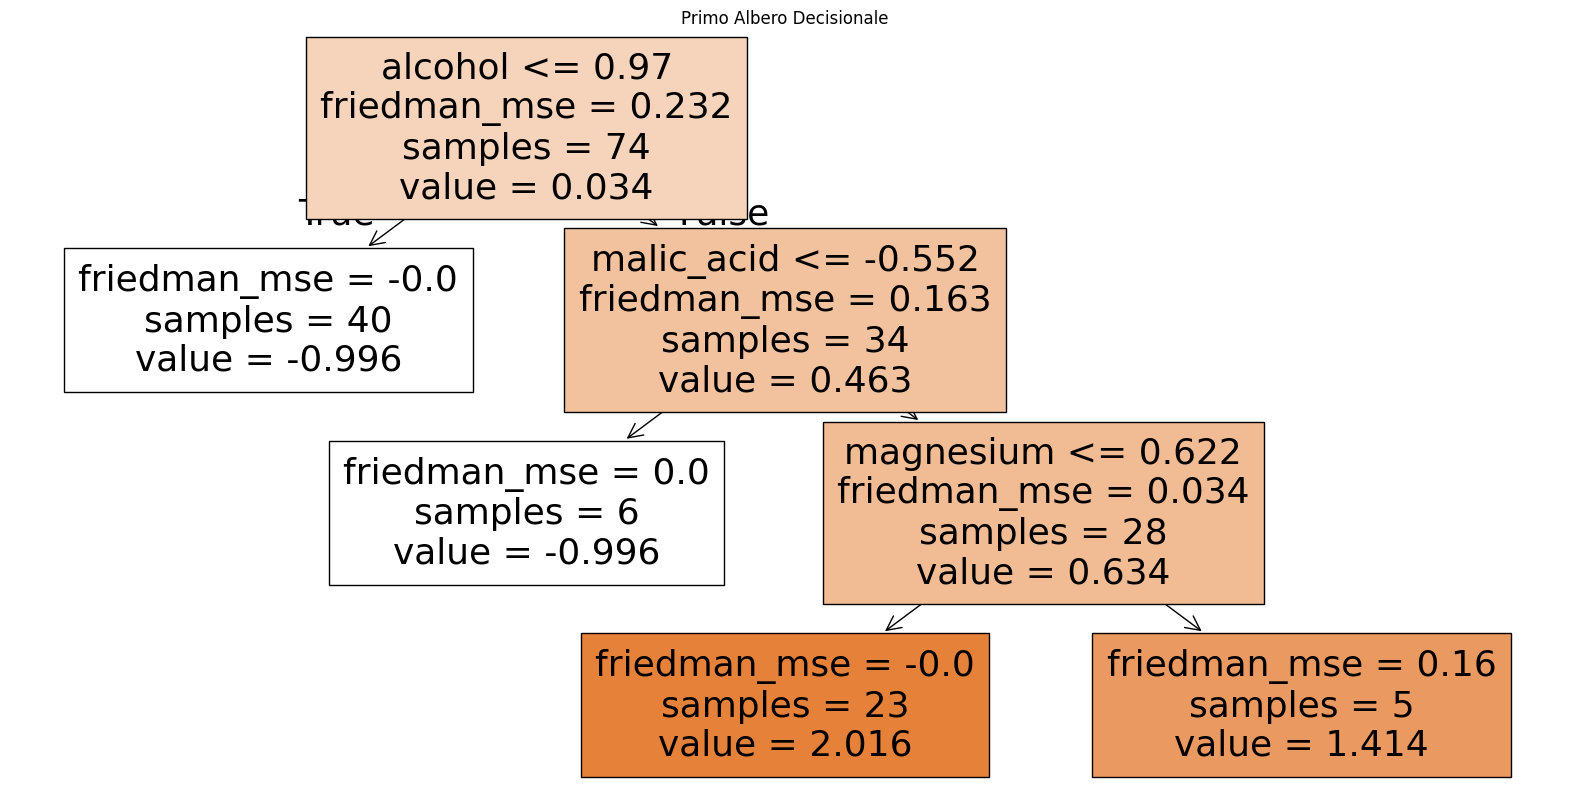

In [9]:
from sklearn.tree import plot_tree

# Visualizzare il primo albero nel modello
plt.figure(figsize=(20, 10))
plot_tree(best_model.estimators_[0, 0], feature_names=data.feature_names, filled=True)
plt.title('Primo Albero Decisionale')
plt.show()

<Figure size 1000x800 with 0 Axes>

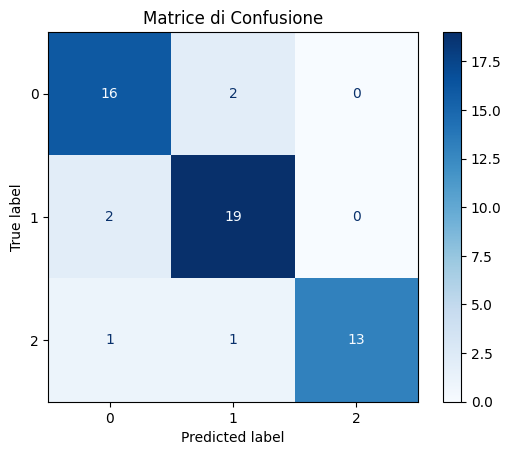

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcolare la matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matrice di Confusione')
plt.show()